In [1]:

from numba.core.extending import get_cython_function_address
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import pytz
import pvlib

# directory with clean and organized data per year for GHI, GTI, DIF, DNI
main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/CLEAN/" 

# directory to save BSRN test results
BSRN_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/BSRN/" 

ghi =  ['GHIP_SI02pt100',
        'GHIP_SMP11',
        'GHIP_SMP22',
        'GHIP_SPN1',
        'GHIT_SMP22']

fghi = ['F_GHIP_SI02pt100', 
        'F_GHIP_SMP11', 
        'F_GHIP_SMP22', 
        'F_GHIP_SPN1', 
        'F_GHIT_SMP22']

gti = ['TGHIP_SI02pt100', 
       'TGHIP_SI02pt100_dirty',
       'TGIP_SMP11_VENT']
      
dif = ['DfHIP_SPN1', 
       'DfHIRP_SMP11',
       'DfHIT_SMP22',
       'DIF_GLO_REF_SPN1']

fdif = ['F_DfHIP_SPN1', 
        'F_DfHIRP_SMP11', 
        'F_DfHIT_SMP22',
        'F_DIF_GLO_REF_SPN1']

dni = ['DNI_SHP1']

fdni = ['F_DNI_SHP1']

months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
          '2021-01']

years = ['2018', '2019', '2020', '2021']
#years = ['2019', '2020', '2021']
#years = ['2020', '2021']



#BSRN TEST

# latitude, longitude, name, altitude, timezone - data retrieved in ETC/GMT - as plotted = noon around 3 pm
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Etc/GMT', altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'Brazil/East' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fghi])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdif])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdni])

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
         -1, #-9999   - apparently did not appear?!?! TEST: create specific flag to track it.
          3, # too low PP
          1, # too low ER
          2, # too high ER
          4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [dif], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [dni], index = [-1, 0, 1, 2, 3, 4], dtype = int) 


#### end definitions

In [2]:
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Etc/GMT', altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'Brazil/East' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fghi])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdif])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdni])

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
         -1, #-9999   - apparently did not appear?!?! TEST: create specific flag to track it.
          3, # too low PP
          1, # too low ER
          2, # too high ER
          4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [dif], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [dni], index = [-1, 0, 1, 2, 3, 4], dtype = int) 

In [3]:
years

['2018', '2019', '2020', '2021']

In [4]:
year = years[0]

In [5]:
year

'2018'

In [6]:
    dfghi = pd.read_pickle(main_path+year+'GHI.pkl')
    #dfgti = pd.read_pickle(main_path+year+'GTI.pkl')
    #dfdif = pd.read_pickle(main_path+year+'DIF.pkl')
    #dfdni = pd.read_pickle(main_path+year+'DNI.pkl')

    dfghi.index = dfghi.index.tz_localize(location.tz)
    #dfgti.index = dfgti.index.tz_localize(location.tz)
    #dfdif.index = dfdif.index.tz_localize(location.tz)
    #dfdni.index = dfdni.index.tz_localize(location.tz)

    naive_times = pd.date_range(start = dfghi.index.min(), end = dfghi.index.max(), freq='1s', tz = location.tz)
    naive_times = pd.DatetimeIndex(naive_times)   # PROBLEM: WILL HAVE TO DEAL WITH MISSING VALUES

    missing.loc[year] = (len(naive_times) - len(dfghi.index))/3600/24

    eth = pvlib.irradiance.get_extra_radiation(naive_times, solar_constant = 1366.1, method = 'nrel').to_frame()
    solpos = pvlib.solarposition.get_solarposition(naive_times, location.latitude, location.longitude, location.altitude, pressure = 101293, temperature = 25)

    #cosSZA = pd.DataFrame(index = naive_times, columns=['caz'])
    cosSZA = np.cos(np.deg2rad(solpos.azimuth)).to_frame()
   
    ghiFLAG['PPmax'] = eth[0]*1.5*(cosSZA.azimuth**(1.2)) + 100   # PPMAX TOO LOW! CHECK PROBLEMS WITH CALCULATION
    ghiFLAG['PPmin'] = PPmin
    ghiFLAG['ERmax'] = eth[0]*1.2*(cosSZA.azimuth**(1.2)) + 50
    ghiFLAG['ERmin'] = ERmin


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


In [11]:
    ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', 
                                  'F_GHIP_SI02pt100', 'F_GHIP_SMP11', 
                                  'F_GHIP_SMP22', 'F_GHIP_SPN1', 'F_GHIT_SMP22'])
    
    ghiFLAG['PPmax'] = eth[0]*1.5*(cosSZA.azimuth**(1.2)) + 100   # PPMAX TOO LOW! CHECK PROBLEMS WITH CALCULATION
    ghiFLAG['PPmin'] = PPmin
    ghiFLAG['ERmax'] = eth[0]*1.2*(cosSZA.azimuth**(1.2)) + 50
    ghiFLAG['ERmin'] = ERmin


In [12]:
   ghiFLAG = pd.merge(ghiFLAG, dfghi, left_index = True, right_index = True, how = 'outer')

In [13]:
solpos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2018-01-01 00:00:00+00:00,110.663146,110.663146,-20.663146,-20.663146,228.196556,-3.326452
2018-01-01 00:00:01+00:00,110.665902,110.665902,-20.665902,-20.665902,228.193709,-3.326457
2018-01-01 00:00:02+00:00,110.668658,110.668658,-20.668658,-20.668658,228.190861,-3.326462
2018-01-01 00:00:03+00:00,110.671415,110.671415,-20.671415,-20.671415,228.188013,-3.326468
2018-01-01 00:00:04+00:00,110.674171,110.674171,-20.674171,-20.674171,228.185165,-3.326473
...,...,...,...,...,...,...
2018-12-31 17:20:00+00:00,28.111393,28.119990,61.888607,61.880010,272.000620,-3.063584
2018-12-31 17:20:01+00:00,28.115087,28.123685,61.884913,61.876315,271.998461,-3.063589
2018-12-31 17:20:02+00:00,28.118781,28.127381,61.881219,61.872619,271.996303,-3.063595
2018-12-31 17:20:03+00:00,28.122475,28.131076,61.877525,61.868924,271.994146,-3.063600


In [16]:
eth.shape

(31512005, 1)

In [17]:
ghiFLAG.shape

(31690884, 14)

In [29]:
eth


,0
2018-01-01 00:00:00+00:00,1412.893619
2018-01-01 00:00:01+00:00,1412.893619
2018-01-01 00:00:02+00:00,1412.893620
2018-01-01 00:00:03+00:00,1412.893620
2018-01-01 00:00:04+00:00,1412.893621
...,...
2018-12-31 17:20:00+00:00,1412.854349
2018-12-31 17:20:01+00:00,1412.854350
2018-12-31 17:20:02+00:00,1412.854350
2018-12-31 17:20:03+00:00,1412.854351


In [33]:
eth.rename(columns= {0: "eth"}, inplace=True)

In [34]:
eth

,eth
2018-01-01 00:00:00+00:00,1412.893619
2018-01-01 00:00:01+00:00,1412.893619
2018-01-01 00:00:02+00:00,1412.893620
2018-01-01 00:00:03+00:00,1412.893620
2018-01-01 00:00:04+00:00,1412.893621
...,...
2018-12-31 17:20:00+00:00,1412.854349
2018-12-31 17:20:01+00:00,1412.854350
2018-12-31 17:20:02+00:00,1412.854350
2018-12-31 17:20:03+00:00,1412.854351


In [19]:
ghiFLAG

,PPmax,PPmin,ERmax,ERmin,F_GHIP_SI02pt100,F_GHIP_SMP11,F_GHIP_SMP22,F_GHIP_SPN1,F_GHIT_SMP22,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
2018-01-01 00:00:00+00:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,-0.059,-2.2,0.3,0.825,0.0
2018-01-01 00:00:01+00:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,-0.059,-2.2,0.3,2.311,0.0
2018-01-01 00:00:02+00:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,0.000,-2.2,0.3,1.321,0.0
2018-01-01 00:00:03+00:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,0.000,-2.2,0.3,2.807,0.0
2018-01-01 00:00:04+00:00,NaN,-4,NaN,-2,NaN,NaN,NaN,NaN,NaN,-0.059,-2.2,0.3,1.651,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 17:20:00+00:00,137.821009,-4,80.256807,-2,NaN,NaN,NaN,NaN,NaN,872.000,893.0,905.0,889.000,902.0
2018-12-31 17:20:01+00:00,137.772068,-4,80.217654,-2,NaN,NaN,NaN,NaN,NaN,873.000,893.0,905.0,889.000,902.0
2018-12-31 17:20:02+00:00,137.723145,-4,80.178516,-2,NaN,NaN,NaN,NaN,NaN,873.000,892.0,904.0,886.000,902.0
2018-12-31 17:20:03+00:00,137.674240,-4,80.139392,-2,NaN,NaN,NaN,NaN,NaN,873.000,892.0,905.0,888.000,902.0


In [21]:
naive_times.shape

(31512005,)

In [22]:
dfghi.shape

(29806375, 5)

In [26]:
print('dfghi.shape =', dfghi.shape, year)

dfghi.shape = (29806375, 5) 2018


In [36]:
df = pd.read_csv('/Users/nataly/opt/AnacondaProjects/SAPIENS/original/GERACAO/CR1000-Sapiens_HT_SP1_INV_CDT.csv')


In [39]:
df.columns

Index(['TIMESTAMP', 'RECORD', 'INV_CDTE_230', 'INV_CDTE_231', 'INV_CDTE_232',
       'INV_CDTE_233', 'INV_CDTE_234', 'INV_CDTE_235', 'INV_CDTE_236',
       'INV_CDTE_237', 'INV_CDTE_238', 'INV_CDTE_239', 'INV_CDTE_240',
       'INV_CDTE_241', 'INV_CDTE_242', 'INV_CDTE_243', 'INV_CDTE_244',
       'INV_CDTE_245', 'INV_CDTE_246', 'INV_CDTE_247', 'INV_CDTE_248',
       'INV_CDTE_330', 'INV_CDTE_331', 'INV_CDTE_332', 'INV_CDTE_333',
       'INV_CDTE_334', 'INV_CDTE_335', 'INV_CDTE_336', 'INV_CDTE_337',
       'INV_CDTE_338', 'INV_CDTE_339', 'INV_CDTE_340', 'INV_CDTE_341',
       'INV_CDTE_342', 'INV_CDTE_343', 'INV_CDTE_344', 'INV_CDTE_345',
       'INV_CDTE_346', 'INV_CDTE_347', 'INV_CDTE_348'],
      dtype='object')

In [40]:
dfsi = pd.read_csv('/Users/nataly/opt/AnacondaProjects/SAPIENS/original/GERACAO/CR1000-Sapiens_HT_SP1_INV_PSI.csv')


In [42]:
dfsi.columns

Index(['TIMESTAMP', 'RECORD', 'INV_PSI_430', 'INV_PSI_431', 'INV_PSI_432',
       'INV_PSI_433', 'INV_PSI_434', 'INV_PSI_435', 'INV_PSI_436',
       'INV_PSI_437', 'INV_PSI_438', 'INV_PSI_439', 'INV_PSI_440',
       'INV_PSI_441', 'INV_PSI_442', 'INV_PSI_443', 'INV_PSI_444',
       'INV_PSI_445', 'INV_PSI_446', 'INV_PSI_447', 'INV_PSI_448'],
      dtype='object')

In [43]:
dfsi.dtypes

TIMESTAMP       object
RECORD           int64
INV_PSI_430    float64
INV_PSI_431    float64
INV_PSI_432    float64
INV_PSI_433    float64
INV_PSI_434    float64
INV_PSI_435    float64
INV_PSI_436    float64
INV_PSI_437    float64
INV_PSI_438    float64
INV_PSI_439    float64
INV_PSI_440    float64
INV_PSI_441    float64
INV_PSI_442    float64
INV_PSI_443      int64
INV_PSI_444      int64
INV_PSI_445      int64
INV_PSI_446    float64
INV_PSI_447    float64
INV_PSI_448    float64
dtype: object

In [45]:
dfsi.TIMESTAMP.max()

'2021-02-11 15:03:00'

In [46]:
dfsi.TIMESTAMP.min()

'2017-10-30 11:30:00'

In [47]:
df.TIMESTAMP.max()

'2021-02-11 15:13:00'

In [48]:
df.TIMESTAMP.min()

'2017-07-04 10:45:00'

In [49]:
        df['TIMESTAMP'] = df['TIMESTAMP'].astype(np.datetime64)


In [51]:
df = df.set_index('TIMESTAMP')

<AxesSubplot:xlabel='TIMESTAMP'>

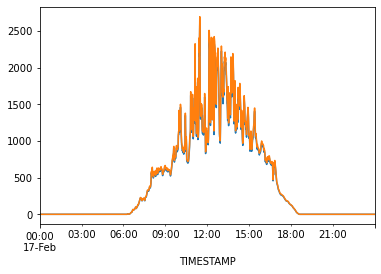

In [56]:
df.INV_CDTE_238.loc['2018-02-17'].plot()
df.INV_CDTE_240.loc['2018-02-17'].plot()

In [58]:
df['INV_CDTE_238']

TIMESTAMP
2017-07-04 10:45:00    1434.9640
2017-07-04 10:46:00    1439.2920
2017-07-04 10:47:00    1441.4260
2017-07-04 10:48:00    1450.1460
2017-07-04 10:49:00    1456.0430
                         ...    
2021-02-11 15:09:00     552.9396
2021-02-11 15:10:00     590.6448
2021-02-11 15:11:00     598.1732
2021-02-11 15:12:00     597.4203
2021-02-11 15:13:00     602.2512
Name: INV_CDTE_238, Length: 1833804, dtype: float64

In [59]:
df['INV_CDTE_240']

TIMESTAMP
2017-07-04 10:45:00    1479.3440
2017-07-04 10:46:00    1484.0010
2017-07-04 10:47:00    1486.0060
2017-07-04 10:48:00    1495.5130
2017-07-04 10:49:00    1501.0760
                         ...    
2021-02-11 15:09:00     570.0408
2021-02-11 15:10:00     608.0389
2021-02-11 15:11:00     615.9943
2021-02-11 15:12:00     615.8973
2021-02-11 15:13:00     620.7158
Name: INV_CDTE_240, Length: 1833804, dtype: float64

In [60]:
df = {}

In [61]:
df

{}